In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

In [2]:
!git clone https://github.com/MalinduLiyanage/Buddha_Statue_Inpainting_Pix2Pix.git

Cloning into 'Buddha_Statue_Inpainting_Pix2Pix'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 40 (delta 1), reused 0 (delta 0), pack-reused 36 (from 1)
Receiving objects: 100% (40/40), 211.26 MiB | 15.26 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Updating files: 100% (10/10), done.


In [3]:
%cd /content/Buddha_Statue_Inpainting_Pix2Pix/saved_checkpoints
!cat training_checkpoints_part_* > training_checkpoints.zip
!rm -f  training_checkpoints_part_*
!file /content/Buddha_Statue_Inpainting_Pix2Pix/saved_checkpoints/training_checkpoints.zip
!mkdir -p /content/Buddha_Statue_Inpainting_Pix2Pix/training_checkpoints
!unzip /content/Buddha_Statue_Inpainting_Pix2Pix/saved_checkpoints/training_checkpoints.zip -d /content/Buddha_Statue_Inpainting_Pix2Pix/training_checkpoints/

/content/Buddha_Statue_Inpainting_Pix2Pix/saved_checkpoints
/content/Buddha_Statue_Inpainting_Pix2Pix/saved_checkpoints/training_checkpoints.zip: Zip archive data, at least v1.0 to extract, compression method=store
Archive:  /content/Buddha_Statue_Inpainting_Pix2Pix/saved_checkpoints/training_checkpoints.zip
   creating: /content/Buddha_Statue_Inpainting_Pix2Pix/training_checkpoints/content/training_checkpoints/
  inflating: /content/Buddha_Statue_Inpainting_Pix2Pix/training_checkpoints/content/training_checkpoints/checkpoint  
  inflating: /content/Buddha_Statue_Inpainting_Pix2Pix/training_checkpoints/content/training_checkpoints/ckpt-8.index  
  inflating: /content/Buddha_Statue_Inpainting_Pix2Pix/training_checkpoints/content/training_checkpoints/ckpt-8.data-00000-of-00001  
   creating: /content/Buddha_Statue_Inpainting_Pix2Pix/training_checkpoints/content/training_checkpoints/.ipynb_checkpoints/


In [4]:
# Define the path to the uploaded tar.gz file
#uploaded_file_path = '/content/buddha.tar.gz'  # Update this if the filename or path differs
uploaded_file_path = '/content/Buddha_Statue_Inpainting_Pix2Pix/Dataset/buddha.tar.gz'

In [5]:
import tensorflow as tf
import pathlib
import tarfile

# Extract the contents of the tar.gz file
with tarfile.open(uploaded_file_path, 'r:gz') as tar:
    tar.extractall(path='/content/')  # Extract to /content directory

# Set the dataset name based on the extracted folder
dataset_name = 'buddha'  # Ensure this matches the extracted folder name
PATH = pathlib.Path(f'/content/{dataset_name}')  # Set the path to the extracted dataset

print(f"Dataset extracted to: {PATH}")


Dataset extracted to: /content/buddha


In [6]:
list(PATH.parent.iterdir())

[PosixPath('/content/.config'),
 PosixPath('/content/Buddha_Statue_Inpainting_Pix2Pix'),
 PosixPath('/content/buddha'),
 PosixPath('/content/sample_data')]

In [7]:
sample_image = tf.io.read_file(str(PATH / 'train/24.png'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


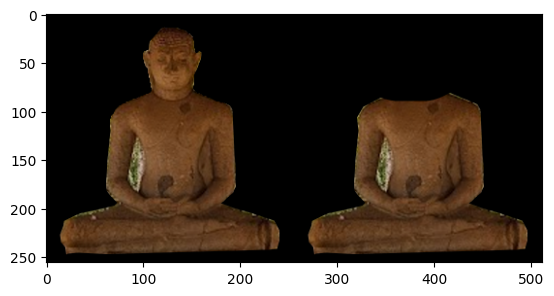

In [8]:
plt.figure()
plt.imshow(sample_image)

In [9]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real statue image
  # - one with an headless statue image
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

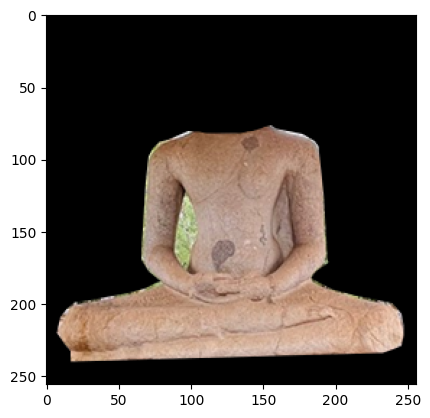

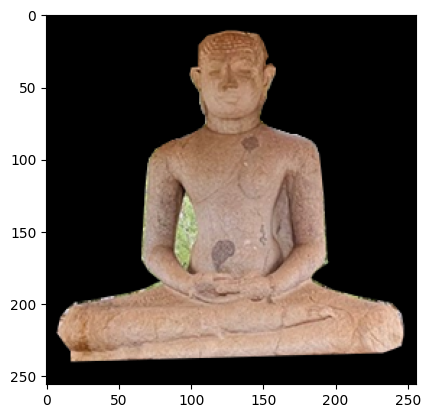

In [10]:
inp, re = load(str(PATH / 'train/35.png'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [11]:
# The facade training set consist of 54 images
BUFFER_SIZE = 54
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [12]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [13]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [14]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [15]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

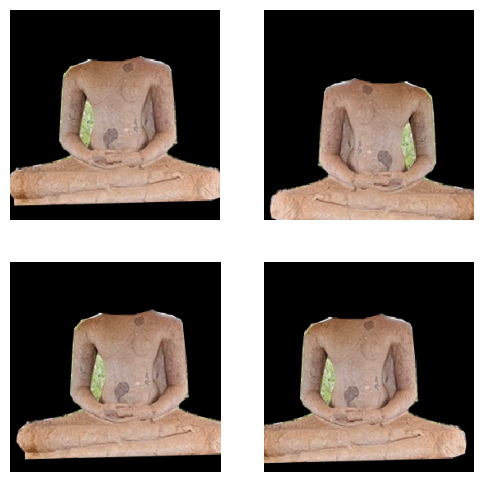

In [16]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

In [17]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [18]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [19]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.png'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [20]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.png'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.png'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [21]:
OUTPUT_CHANNELS = 3

In [22]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [23]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [24]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [25]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [26]:
#Simplified Generator
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),   # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

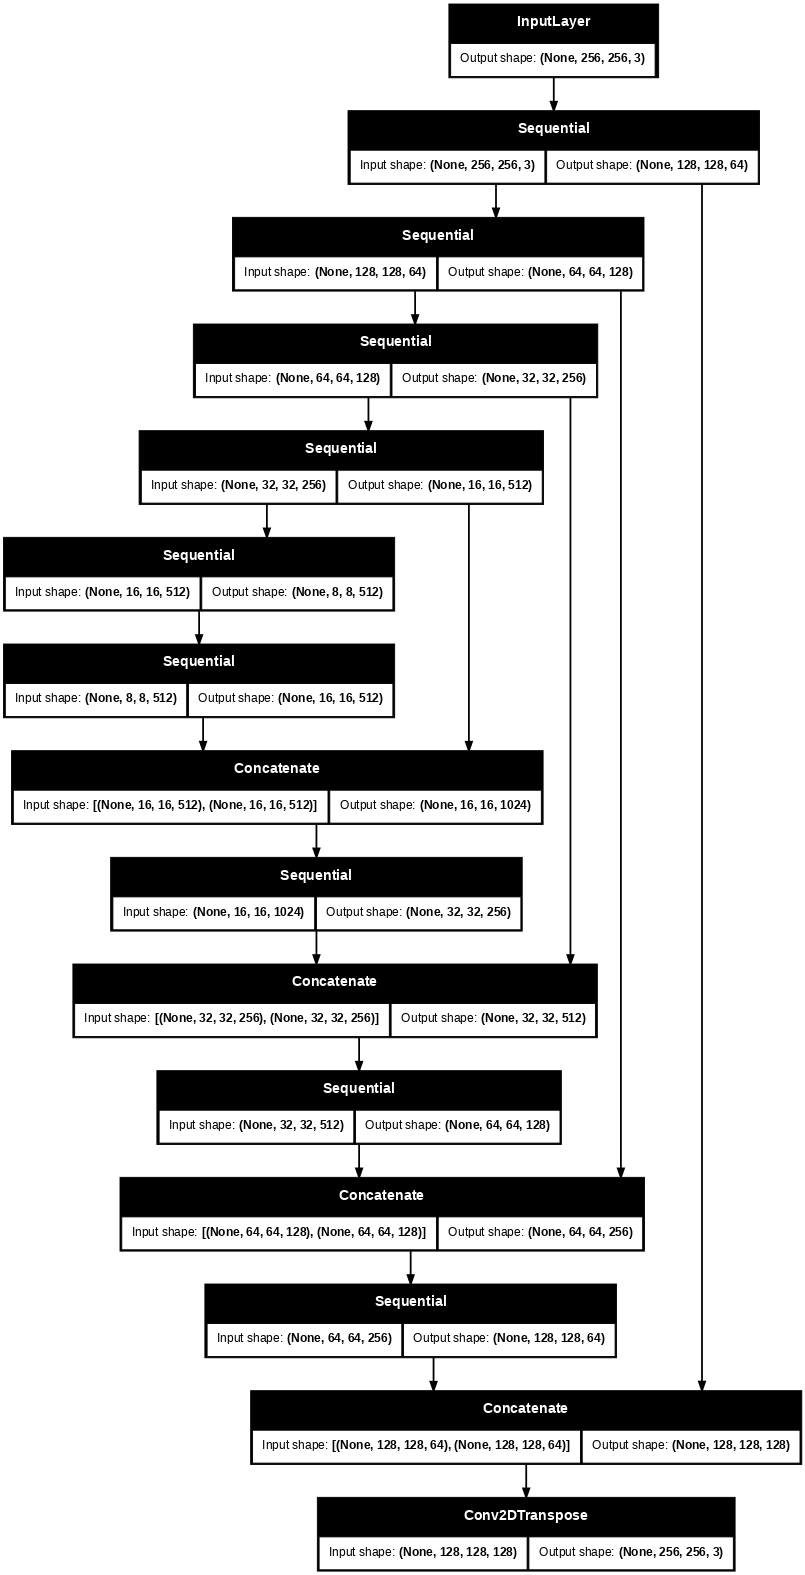

In [27]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

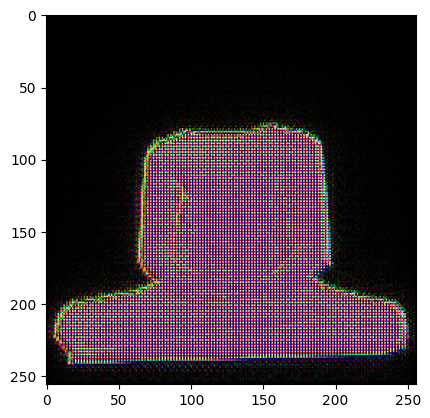

In [28]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [29]:
LAMBDA = 100

In [30]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [31]:
# Define SSIM weight
SSIM_WEIGHT = 0.1

# Modify the generator loss function to include SSIM
def generator_loss(disc_generated_output, gen_output, target):
    # GAN Loss (Binary Cross-Entropy)
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # L1 Loss (Mean Absolute Error)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    # SSIM Loss (Structural Similarity)
    ssim_loss = tf.reduce_mean(tf.image.ssim(target, gen_output, max_val=1.0))

    # Total generator loss combining GAN, L1, and SSIM
    total_gen_loss = gan_loss + (LAMBDA * l1_loss) - (SSIM_WEIGHT * ssim_loss)

    return total_gen_loss, gan_loss, l1_loss, ssim_loss

In [32]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

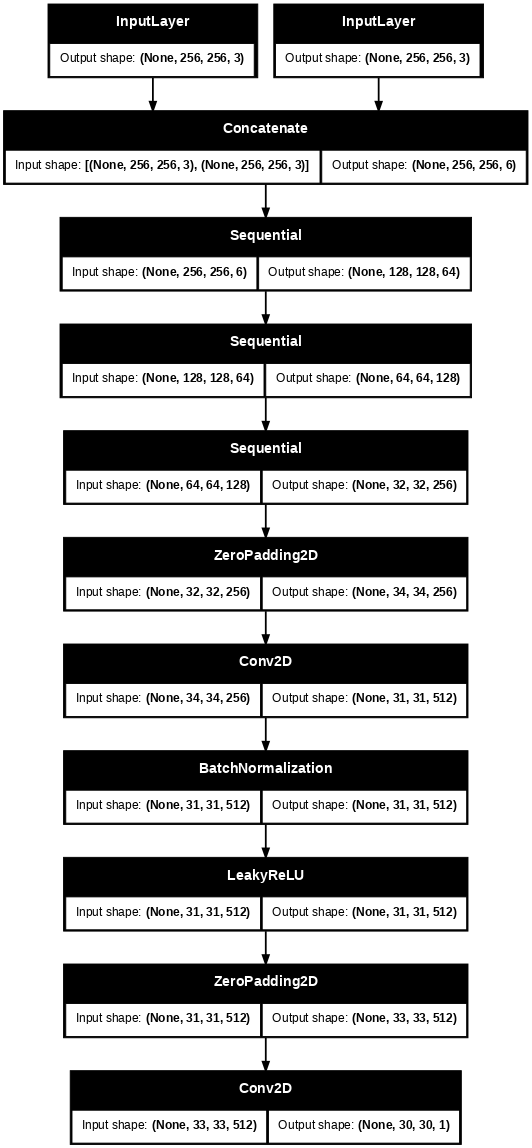

In [33]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

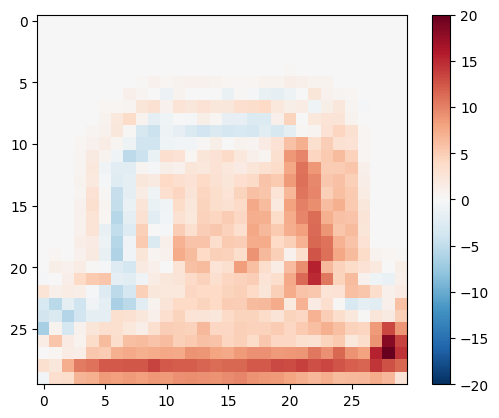

In [34]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [35]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [36]:
#Updated Optimizer
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.7)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.7)


In [37]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [38]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

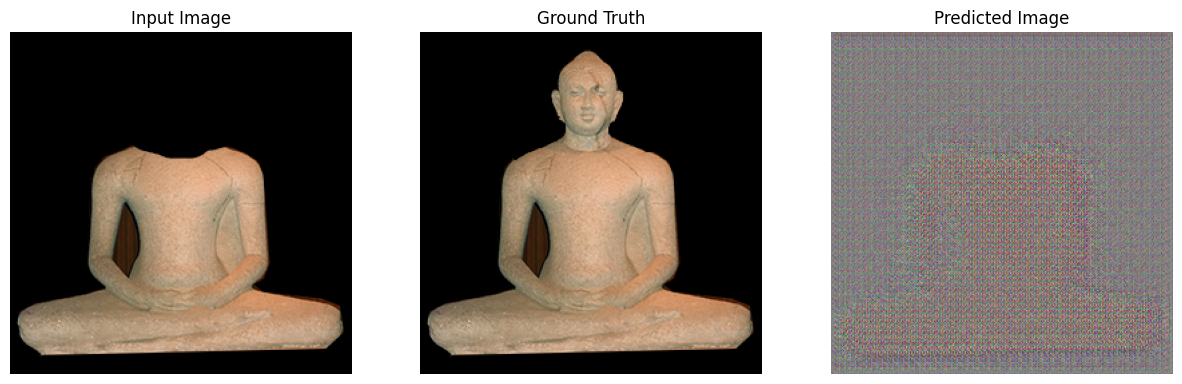

In [39]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [40]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [41]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss, gen_ssim_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('gen_ssim_loss', gen_ssim_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

    # Return the losses in a dictionary to be used in loss tracking
    return {
        "gen_total_loss": gen_total_loss,
        "disc_loss": disc_loss,
        "gen_gan_loss": gen_gan_loss,
        "gen_l1_loss": gen_l1_loss,
        "gen_ssim_loss": gen_ssim_loss,
    }



In [42]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if step % 1000 == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f'Time taken for 1000 steps: {time.time() - start:.2f} sec\n')

            start = time.time()
            generate_images(generator, example_input, example_target)
            print(f"Step: {step // 1000}k")

            # Plot the losses every 1000 steps
            plot_losses(loss_history, step)

        # Train step and update loss history
        losses = train_step(input_image, target, step)
        update_loss_history(losses)  # Track each loss after every training step

        # Progress feedback
        if (step + 1) % 10 == 0:
            print('.', end='', flush=True)

        # Save checkpoint every 5000 steps
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)


In [43]:
# Loss tracking dictionary and functions
loss_history = {
    "gen_total_loss": [],
    "gen_gan_loss": [],
    "gen_l1_loss": [],
    "disc_loss": [],
    "gen_ssim_loss": [],

}

def update_loss_history(losses):
    for key, value in losses.items():
        loss_history[key].append(value)

def plot_losses(loss_history, step):
    plt.figure(figsize=(12, 8))
    plt.suptitle(f"Training Losses up to Step {step}")

    # Plot Generator Losses
    plt.subplot(2, 1, 1)
    plt.plot(loss_history["gen_total_loss"], label="Generator Total Loss", color="b")
    plt.plot(loss_history["gen_gan_loss"], label="Generator GAN Loss", color="c")
    plt.plot(loss_history["gen_l1_loss"], label="Generator L1 Loss", color="m")
    plt.plot(loss_history["gen_ssim_loss"], label="Generator SSIM Loss", color="g")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Generator Losses")

    # Plot Discriminator Loss
    plt.subplot(2, 1, 2)
    plt.plot(loss_history["disc_loss"], label="Discriminator Loss", color="r")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Discriminator Loss")

    plt.tight_layout()
    plt.show()


In [44]:
# Import TensorFlow summary for TensorBoard logging
log_dir = "./logs/"
summary_writer = tf.summary.create_file_writer(log_dir)


Time taken for 1000 steps: 68.03 sec



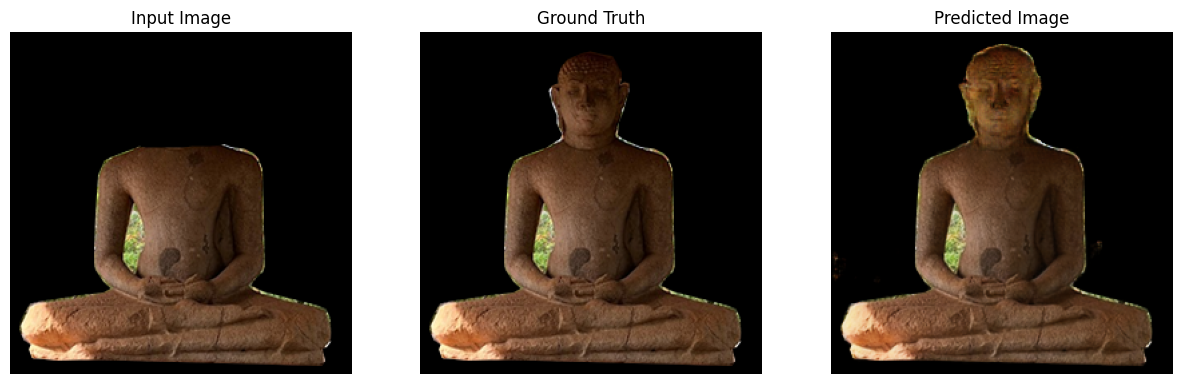

Step: 39k


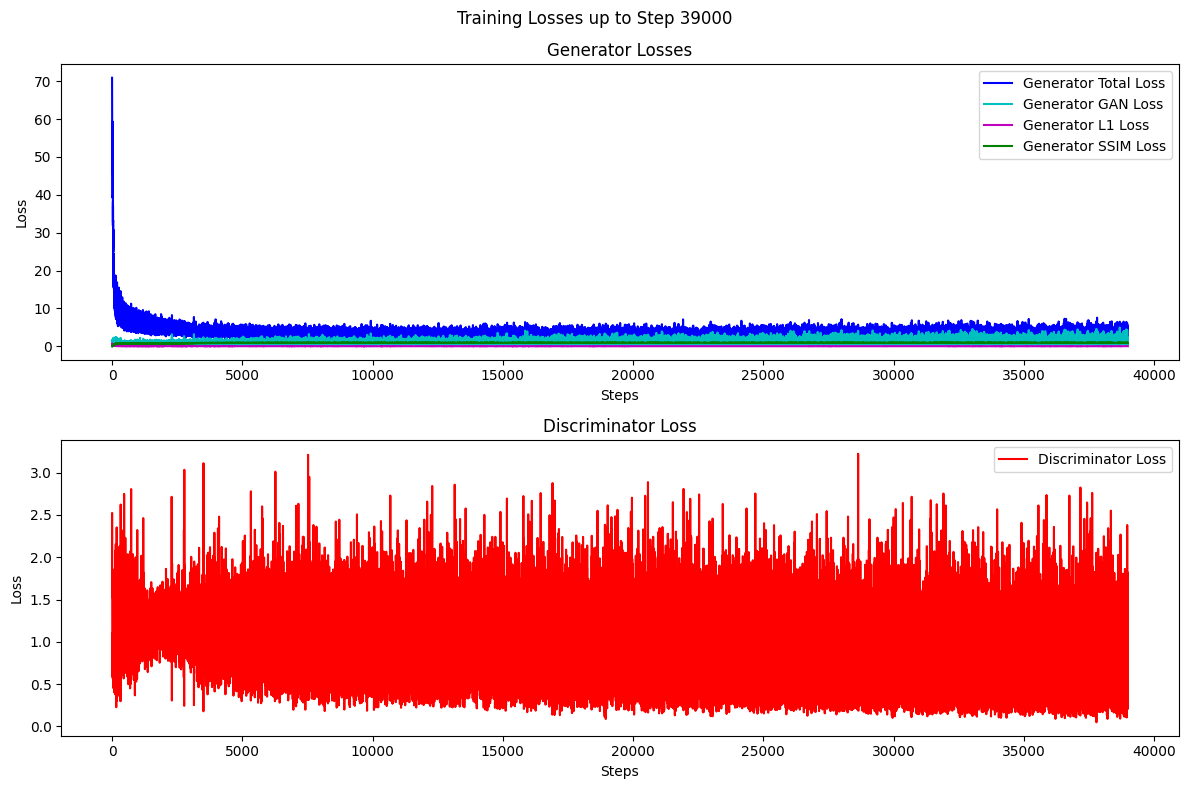

....................................................................................................

In [ ]:
fit(train_dataset, test_dataset, steps=40000)

In [ ]:
#Save checkpoints to Google Drive
from google.colab import drive
drive.mount('/content/drive')
!cp -r /content/training_checkpoints /content/drive/MyDrive/
!ls /content/drive/MyDrive/training_checkpoints

Mounted at /content/drive
checkpoint		    ckpt-3.index		ckpt-6.index
ckpt-1.data-00000-of-00001  ckpt-4.data-00000-of-00001	ckpt-7.data-00000-of-00001
ckpt-1.index		    ckpt-4.index		ckpt-7.index
ckpt-2.data-00000-of-00001  ckpt-5.data-00000-of-00001	ckpt-8.data-00000-of-00001
ckpt-2.index		    ckpt-5.index		ckpt-8.index
ckpt-3.data-00000-of-00001  ckpt-6.data-00000-of-00001


In [ ]:
#Load Checkpoints from Google Drive
from google.colab import drive
drive.mount('/content/drive/')

checkpoint_dir = '/content/drive/MyDrive/training_checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Mounted at /content/drive/


In [45]:
#Load Checkpoints from Git Repo

checkpoint_dir = '/content/Buddha_Statue_Inpainting_Pix2Pix/training_checkpoints/content/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [46]:
!ls {checkpoint_dir}
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

checkpoint  ckpt-8.data-00000-of-00001	ckpt-8.index


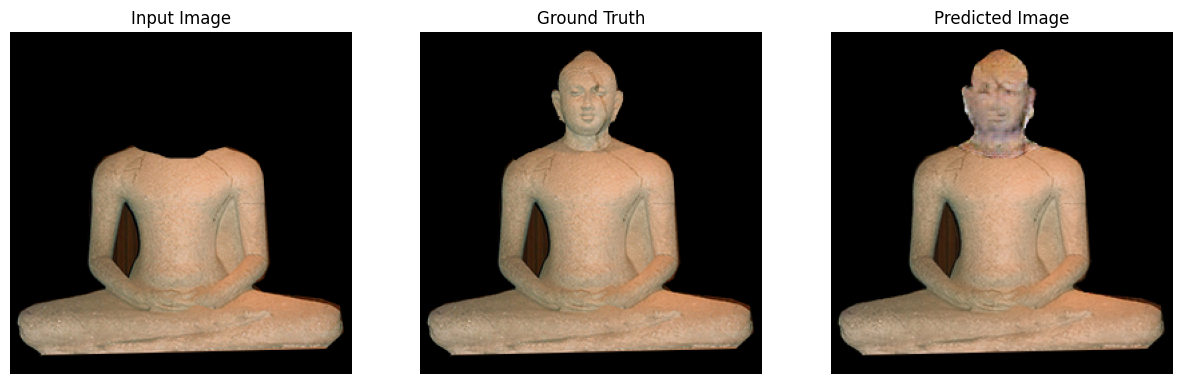

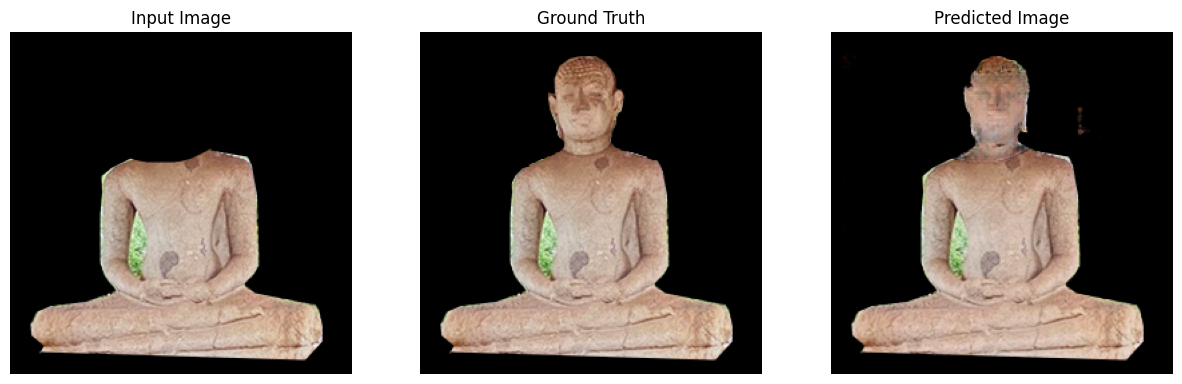

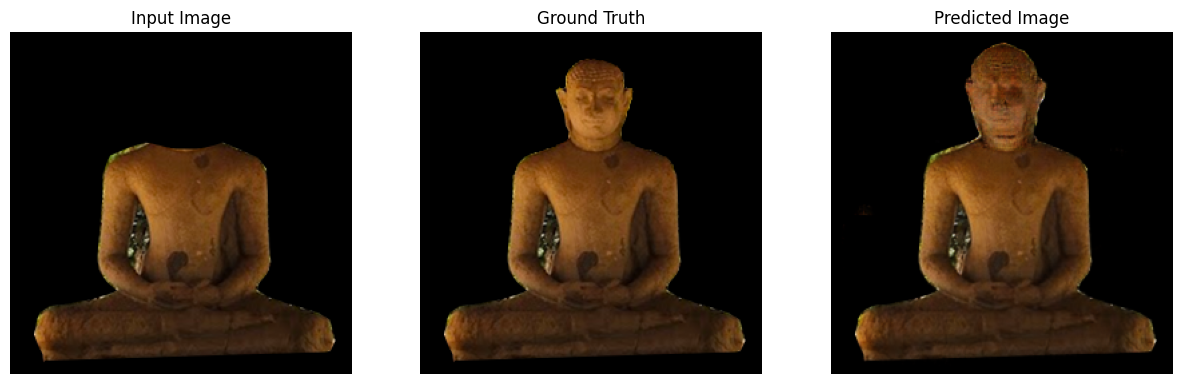

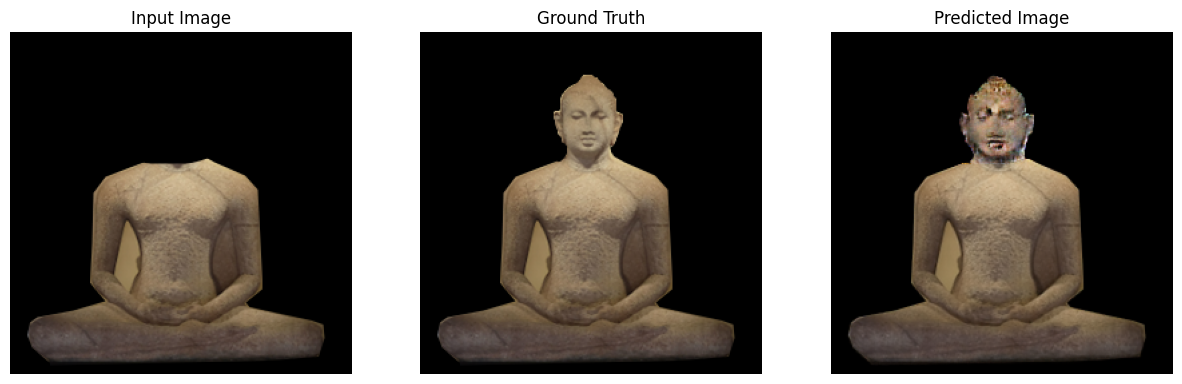

In [47]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(10):
  generate_images(generator, inp, tar)

In [48]:
import tensorflow as tf
import pickle

# Re-run a few test steps to calculate the losses (make sure your test data is available)
def calculate_final_losses(test_data):
    final_loss_values = {
        "gen_gan_loss": [],
        "gen_l1_loss": [],
        "gen_ssim_loss": [],
        "disc_loss": []
    }

    for input_image, target in test_data:
        # Recreate the training step
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_output = generator(input_image, training=False)

            disc_real_output = discriminator([input_image, target], training=False)
            disc_generated_output = discriminator([input_image, gen_output], training=False)

            # Compute losses
            gen_total_loss, gen_gan_loss, gen_l1_loss, gen_ssim_loss = generator_loss(disc_generated_output, gen_output, target)
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        # Save the loss values for later
        final_loss_values["gen_gan_loss"].append(gen_gan_loss.numpy())
        final_loss_values["gen_l1_loss"].append(gen_l1_loss.numpy())
        final_loss_values["gen_ssim_loss"].append(gen_ssim_loss.numpy())
        final_loss_values["disc_loss"].append(disc_loss.numpy())

    # Print the final loss values
    print("\nFinal loss values after testing:")
    print(f"Final Generator GAN Loss: {final_loss_values['gen_gan_loss'][-1]:.4f}")
    print(f"Final Generator L1 Loss: {final_loss_values['gen_l1_loss'][-1]:.4f}")
    print(f"Final Generator SSIM Loss: {final_loss_values['gen_ssim_loss'][-1]:.4f}")
    print(f"Final Discriminator Loss: {final_loss_values['disc_loss'][-1]:.4f}")

# Assuming you have a test dataset `test_dataset`
calculate_final_losses(test_dataset)



Final loss values after testing:
Final Generator GAN Loss: 1.8615
Final Generator L1 Loss: 0.0233
Final Generator SSIM Loss: 0.8907
Final Discriminator Loss: 2.6129


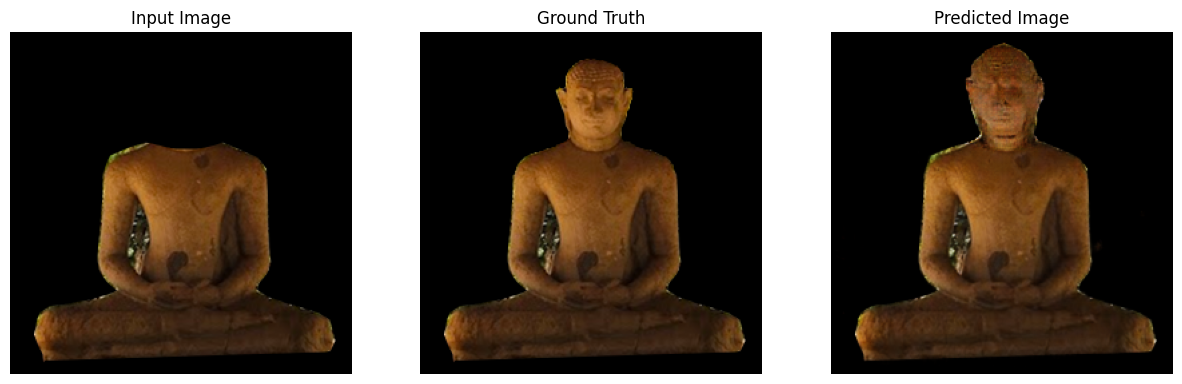

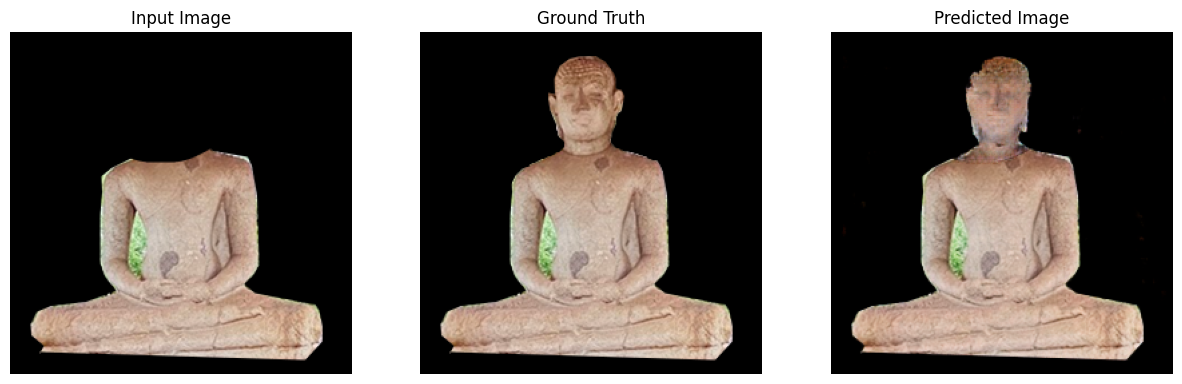

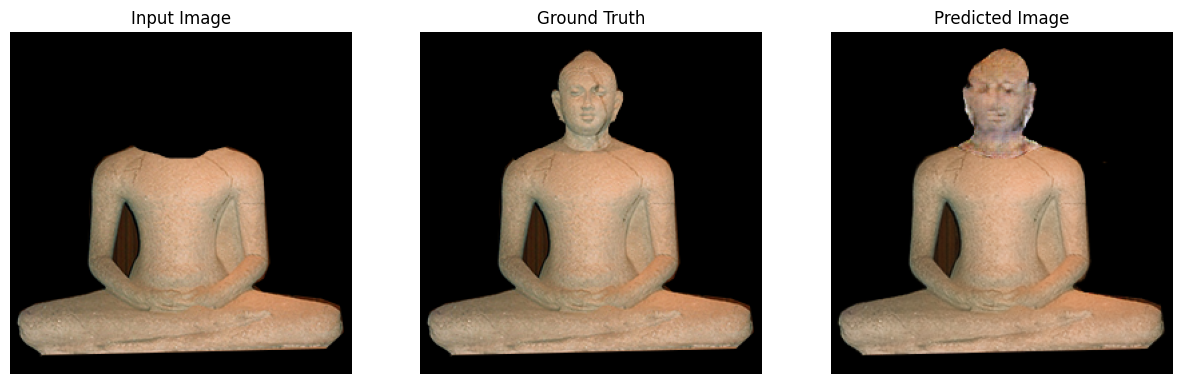

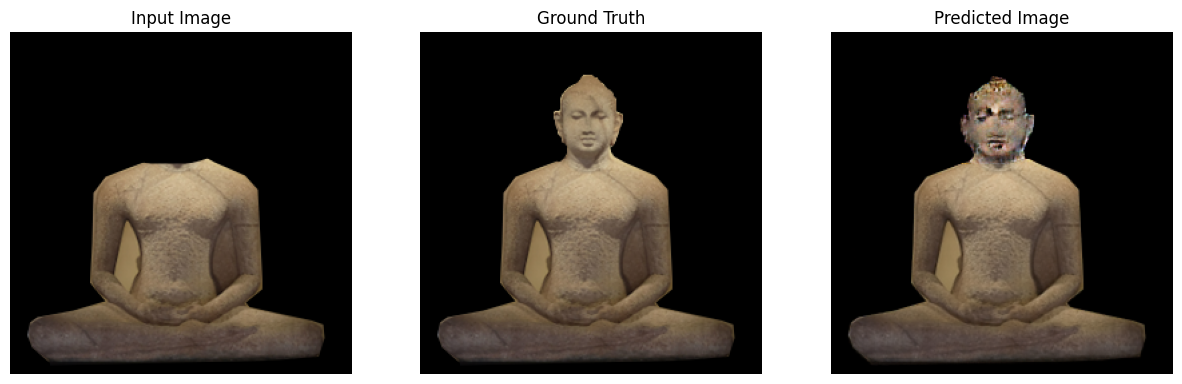

Average MAE: 0.0268
Average SSIM: 0.9175
        Test Case       MAE      SSIM
0             1.0  0.024844  0.923690
1             2.0  0.017660  0.943401
2             3.0  0.040716  0.913265
3             4.0  0.023242  0.890602
Average   Average  0.026615  0.917740


<ipython-input-49-cdfd74a40409>:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Average' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_df.loc["Average", "Test Case"] = "Average"


In [49]:
def calculate_mae(prediction, target):
    return tf.reduce_mean(tf.abs(prediction - target)).numpy()

def calculate_ssim(prediction, target):
    return tf.reduce_mean(tf.image.ssim(prediction, target, max_val=1.0)).numpy()

def evaluate_test_set(generator, test_dataset):
    mae_scores = []
    ssim_scores = []

    for test_input, target in test_dataset:
        # Generate prediction
        prediction = generator(test_input, training=False)

        # Compute metrics
        mae = calculate_mae(prediction, target)
        ssim = calculate_ssim(prediction, target)

        mae_scores.append(mae)
        ssim_scores.append(ssim)

        # Optionally visualize the result
        generate_images(generator, test_input, target)

    # Compute averages
    avg_mae = sum(mae_scores) / len(mae_scores)
    avg_ssim = sum(ssim_scores) / len(ssim_scores)

    print(f"Average MAE: {avg_mae:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")

    return mae_scores, ssim_scores, avg_mae, avg_ssim

mae_scores, ssim_scores, avg_mae, avg_ssim = evaluate_test_set(generator, test_dataset)

import pandas as pd

def evaluate_test_set_as_table(generator, test_dataset):
    results = []

    for idx, (test_input, target) in enumerate(test_dataset):
        # Generate prediction
        prediction = generator(test_input, training=False)

        # Compute metrics
        mae = calculate_mae(prediction, target)
        ssim = calculate_ssim(prediction, target)

        # Append results
        results.append({"Test Case": idx + 1, "MAE": mae, "SSIM": ssim})

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Add a row for averages
    results_df.loc["Average"] = results_df.mean(numeric_only=True)
    results_df.loc["Average", "Test Case"] = "Average"

    print(results_df)
    return results_df

results_df = evaluate_test_set_as_table(generator, test_dataset)

